### Introduction

In this tutorial, we will explore differences in data access, size and performance between the `.SAFE` Sentinel-2 L2A Items available at the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) (CDSE) vs. the `.zarr` products available from the [EOPF Sentinel Zarr Sample Service STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en).

### What we will learn

- 💻 An overview of the programmatic performance of `.zarr` vs. the traditional `.SAFE` format over the same item
- 💾 The advantages of cloud based access and processing of `.zarr` data for the Sentinel-2 L2A collection.

### Prerequisites

We recommend revising the [STAC Catalog chapter](33_eopf_stac_connection.ipynb), as it gives you an introduction on how to access a STAC catalog programmatically with python.

As we will be using the traditional `.SAFE` format for comparison, you need a user account inside the [CDSE](https://dataspace.copernicus.eu/). If you have not registered yet, you can create an account [here](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?execution=10f09889-a37b-4bbf-90c9-b833b16ddb55&client_id=account-console&tab_id=KPrlB_gk1KE). <br>

To register a CDSE account and learn about all the data you can access, follow [this tutorial](https://documentation.dataspace.copernicus.eu/Registration.html).

#### Item of Interest

In this workflow, we will compare the same data in two different formats: in `.SAFE` and in `.zarr`. We will focus on an alpine area in Innsbruck, Austria. The data that covers this geographical area of interest for this tutorial is denoted with the ID:

- `S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924`

**Note:** The EOPF Zarr Sample Service currently converts one `.SAFE` item to a single `.zarr` item, meaning they cover the same extent and bounding box. This may change in the future.

ESA is looking forward to developing an entire dataset dedicated to **zarr**, and a new general format will be unified. These efforts are under current development.

To follow the ongoing discussion, visit the [CDSE Forum](https://forum.dataspace.copernicus.eu/) for the latest updates.


<hr>

#### Import libraries

In [1]:
import requests
import sys
import os
from pystac import Collection, MediaType
from pystac_client import Client, CollectionClient
import numpy as np
import xarray as xr
import xml.etree.ElementTree as ET
import time
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import rasterio

#### Helper functions

##### `get_access_token()`

Having a CDSE account allows you to generate tokens to access and download the Sentinel data sets that you are interested in. The CDSE provides a tutorial on how to download items of interest from the Sentinel missions via API through the **OpenData Protocol** (OData).

The `get_access_token()` function below uses your CDSE credentials to generate the tokens required for data retrieval.

In [ ]:
def get_access_token(username: str, password: str) -> str:
    # Define the elements for the request inside CDSE
    data = {
        "client_id": "cdse-public", 
        "username": username, #input credentials
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post( # constructing the request
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
        # Check on correct access
    except Exception as e:
        raise Exception(
            f"Access token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]

##### `get_size()`

The `get_size()` function calculates the loaded bytes from the `.zarr` objects that we are calling from the cloud.

The returned value is defined in megabytes (MB).

In [ ]:
def get_size(element):
    # Define the number of bites contained in the element of interes:
    in_bytes = element.nbytes
    # Calculate size in MB:
    size = (in_bytes) / (1024**2)
    return size

##### `norm_band_safe()`

The `norm_band_safe()` function allows us to normalise the values of our `.SAFE` processed bands as `np.arrays`. This is important because... {describe what normalisation does}

In [ ]:
def norm_band_safe(band_data,enhance_contrast):
    # Remove NaN values for percentile calculation
    valid_data = band_data[~np.isnan(band_data)]
    if len(valid_data) == 0:
        return np.zeros_like(band_data)
    
    if enhance_contrast == True:
        # Use 2nd and 98th percentiles for contrast stretching
        p2, p98 = np.percentile(valid_data, [2, 98])
        normalized = np.clip((band_data - p2) / (p98 - p2), 0, 1)
    else:
        # Simple min-max normalisation
        p2, p98 = np.percentile(valid_data, [2, 98])
        normalized = np.clip((band_data - p2) / (p98 - p2), 0, 1)
        min_val, max_val = np.nanmin(band_data), np.nanmax(band_data)
        normalized = (band_data - min_val) / (max_val - min_val)
    
    # Replace NaN with 0
    normalized[np.isnan(normalized)] = 0

        
    return normalized

##### `norm_band_zarr()`

The `norm_band_zarr()` function normalises the values of our `.zarr` processed assets as `xarrays`, for the same reasons described above.

In [ ]:
def norm_band_zarr (band_data: xr.DataArray, enhance_contrast: bool = False) -> xr.DataArray:
    if band_data.size == 0:
        return xr.zeros_like(band_data)
    # Use 2nd and 98th percentiles for contrast stretching
    if enhance_contrast:
        p2 = band_data.quantile(0.02, skipna=True).compute()
        p98 = band_data.quantile(0.98, skipna=True).compute()

        # Handle potential division by zero if p98 == p2
        if p98 == p2:
            normalized = xr.zeros_like(band_data)
        else:
            normalized = (band_data - p2) / (p98 - p2) # 'normalized' assigned here

        normalized = normalized.clip(0, 1) # This is the line in question.
    else:
        # Simple normalization using xarray's .min() and .max()
        min_val = band_data.min(skipna=True).compute()
        max_val = band_data.max(skipna=True).compute()
        
        if max_val == min_val:
            normalized = xr.zeros_like(band_data)

    # Replace NaN with 0. Xarray's .fillna() method is Dask-aware.
    normalized = normalized.fillna(0)

    return normalized

<hr>

## Connecting to the CDSE

Once we have registered for a CDSE account, we are able to provide the required credentials that will allow us to search and download the files of interest directly to our local machine.

In [ ]:
# Input your CDSE credentials:
user_name = input("Enter your CDSE username (email): ") 
def_pass = input("Enter your CDSE password: ")

As we aim to compare performance response, we will measure the runtime (in other words, how long it takes) for each of the core steps of data access. We will measure the time taken starting from when we provide our credentials and until the data can be accessed in our working space.

Next, we have to provide the URL from the item we are interested in (from the Sentinel-2 L2A data) and create our API request. We will start by accessing a `.SAFE` file.


In [ ]:
st= time.time()   # Starts calculating the access time 
access_token = get_access_token(user_name, def_pass)

# Define the .SAFE Item we are interested in:
url = f'https://download.dataspace.copernicus.eu/odata/v1/Products(fa3a0848-1568-4dc4-9ecb-dabecf23bd4b)/$value'

# Construct the requests:
headers = {"Authorization": f"Bearer {access_token}"}
session = requests.Session()
session.headers.update(headers)
response = session.get(url, headers=headers, stream=True) # storing the requested file

After obtaining a response, we set the parameters to download the `.SAFE` file compressed in a `.zip` archive.

In [ ]:
# Write the retrieved file inside a .zip
with open("sentinel_2_SAFE.zip", "wb") as file:
    for chunk in response.iter_content(chunk_size=1000000):
        if chunk:
            file.write(chunk)

### .`SAFE` access time

In order to get an overview of the structure of the selected file, we can unzip it and access each of the stored bands with the corresponding metadata of the item.

To confirm that we have accessed the correct file, we can check the name of the unzipped object, and ensure that it corresponds to: - `S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924`


In [ ]:
# Unzip the archive
with zipfile.ZipFile("sentinel_2_SAFE.zip", "r") as zip_ref:
    zip_ref.extractall(".") #Extract to the current directory

# Find the extracted .SAFE folder in the current directory
safe_input = [f for f in os.listdir(".") if f.endswith(".SAFE")][0]

print(f"Extracted: {safe_input}")

Extracted: S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.SAFE


The `.SAFE` format is stored based on granules. The granules store (1) the available bands at different resolutions, (2) quality masks and (3) the complementary metadata that allows for the reconstruction and management of the files through different **GIS** software or programming languages.

To calculate the size of the file, we add up the component sizes. Also, we can already measure the total time of `.SAFE` retrieval:

In [10]:
safe_size = sum(os.path.getsize(os.path.join(dp, f)) for dp, dn, filenames in os.walk(safe_input) for f in filenames) / (1024**3)

et = time.time()
safe_download_t = et-st

print('Accessed file: ', safe_input)
print(f"SAFE Directory Size: {safe_size:.3f} GB")
print(f'Running time: {(safe_download_t):.3f} sec')

Accessed file:  S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924.SAFE
SAFE Directory Size: 1.173 GB
Running time: 247.182 sec


## Connecting to the EOPF Zarr STAC Catalog

Next, we will turn our attention to the  `.zarr` format. <br> 

Our first step is to establish a connection to the path where the `.zarr` file is stored inside the **EOPF Zarr STAC Catalog**. This involves requesting the equivalent item stored in the CDSE through the STAC Catalog. Remember that for now, one `.SAFE` item, is equivalent to one `.zarr` item, and by requesting an item with the same ID, we can find the equivalent file inside STAC Catalog:

In [ ]:
st = time.time()

# Defining the equivalent Item of interest based on the defined id:
item_id = 'S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924'

# Defining the entry point for the catalog:
client = Client.open("https://stac.core.eopf.eodc.eu/")

# Filtering the Sentinel-2 L2A collection:
collection = client.get_collection(collection_id="sentinel-2-l2a")
item = collection.get_item(
    id= item_id
)

print('Retrieved :',item_id,'.zarr')

Retrieved : S2B_MSIL2A_20250530T101559_N0511_R065_T32TPT_20250530T130924 .zarr


Once we receive a response, we can proceed to access the storage `URL` embedded inside the assets that compose the item inside the **STAC Catalog**. This reference provides the location of the cloud storage bucket where our `.zarr` of interest is stored.

Then, we can measure the access time taken to connect to the **STAC Catalog** and find the item of interest:

In [ ]:
# Extracting the .zarr 
for asset_name, asset in sorted(
    item.get_assets(media_type=MediaType.ZARR).items(), key=lambda item: item[1].href
):
    roles = asset.roles or []
    # Identify the top-level Zarr group asset. This is what we will access with xarray.
    if "data" in roles and "metadata" in roles:
        stac_object = asset

zarr_url = stac_object.href

### `.zarr` access time

After obtaining the storage location, we can then access the `DataTree` that will allow us to call the assets inside the `.zarr` item that we are interested to explore.

In [ ]:
# Defining the interest item through the selected url
zarr_input = xr.open_datatree(
    zarr_url, engine="zarr") # the retrieved url and the zarr engine.

et = time.time()

zarr_file_t = et-st
print(f'Opening time: {(zarr_file_t):.3f} sec')

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_4288/1804179650.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  zarr_input = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_4288/1804179650.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  zarr_input = xr.open_datatree(


Opening time: 4.382 sec


## Accessing Data

Now that we have connected through the respective spaces and accessed the equivalent data set, we can compare the retrieval procedure and time for our items of interest in `.SAFE` and `.zarr` formats.

As an example, we can take a look at how to access an overview of the **T**rue **C**olor **I**mage (`tci`) at 60m resolution.

Both for .`SAFE` and `.zarr`, the access procedure can be described as it follows.

### `.SAFE` QuickLook

In the case of .SAFE, the `tci` can be located through the `manifest.safe` file. <br>
The retrieval then, includes the construction of the path location and once found, it can be also called and plotted from the `.jp2` format.

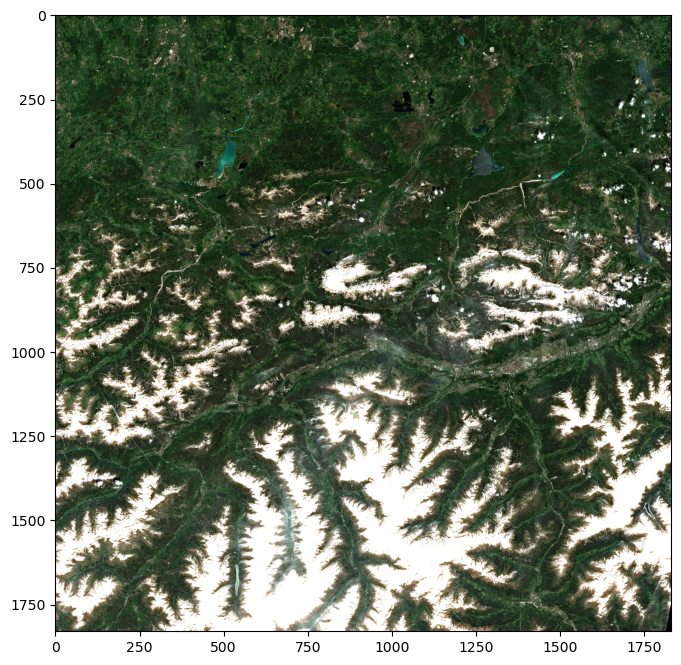

Running time: 0.564 sec
File Size: 3.57 MB
Manifest Size: 0.066 MB


In [ ]:
st = time.time()

# Create the map inside the .SAFE encoding through the manifest.safe file:
xml_manifest_path = os.path.join(safe_input,"manifest.safe")
xml_tree = ET.parse(xml_manifest_path)

# Define the location of the 60m TCI:
file_location_element = xml_tree.getroot().find(
    ".//dataObject[@ID='IMG_DATA_Band_TCI_60m_Tile1_Data']/byteStream/fileLocation"
)
assert file_location_element is not None, "failed to find TCI 60m data"
tci_60m_file_path = os.path.join(
    safe_input, file_location_element.get("href")
)

# Read the TCI:
ql_safe = mpimg.imread(tci_60m_file_path)
ql_safe_60_size =  ql_safe.nbytes/(1024**2)
ql_safe_size = os.path.getsize(tci_60m_file_path)
man_size = os.path.getsize(xml_manifest_path)/(1024**2)

# Create the plot: 
plt.figure(figsize=(8, 8))
plt.imshow(ql_safe)
plt.show()

et = time.time()
safe_ql_t = et-st

print(f'Running time: {(safe_ql_t):.3f} sec')
print(f'File Size: {ql_safe_size /(1024**2):.3} MB')
print(f'Manifest Size: {(man_size):.3f} MB')


### `.zarr` QuickLook

The xarray format, allows us to call the group where the `tci` is stored. For the 60m resolution case, it is stored under the `'quality/l2a_quicklook/r60m'` group.

In [ ]:
st = time.time()

# Extract the 60m resolution group where the TCI is stored:
ql_zarr = zarr_input['quality/l2a_quicklook/r60m'].to_dataset()
print(ql_zarr.info)
ql_zarr = ql_zarr['tci']

<bound method Dataset.info of <xarray.Dataset> Size: 10MB
Dimensions:  (band: 3, y: 1830, x: 1830)
Coordinates:
  * band     (band) int64 24B 1 2 3
  * x        (x) int64 15kB 600030 600090 600150 600210 ... 709650 709710 709770
  * y        (y) int64 15kB 5300010 5299950 5299890 ... 5190390 5190330 5190270
Data variables:
    tci      (band, y, x) uint8 10MB ...>


To access the data, we can select the desired group and its metadata will allow us to reconstruct an overview of the asset, which can be then plotted for a visual explore.

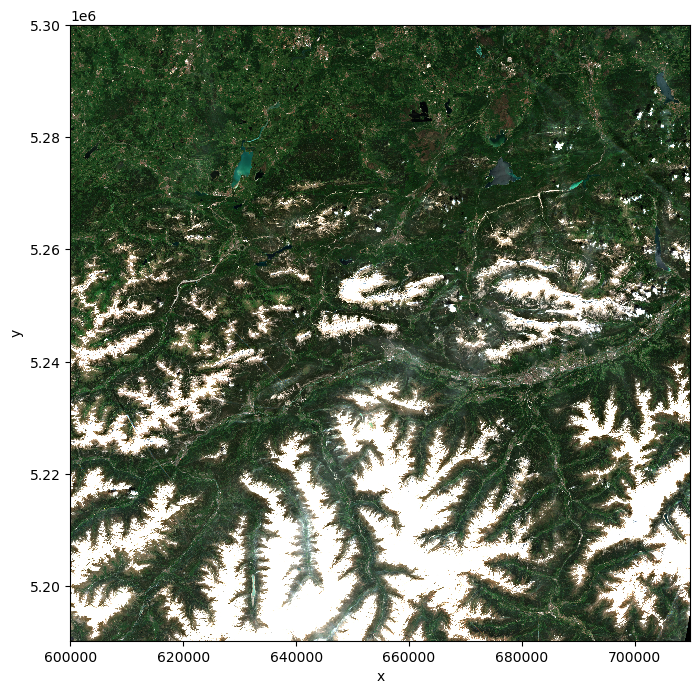

Running time: 1.439 sec
Object  9.581279754638672


In [ ]:
# Create the plot:
plt.figure(figsize=(8, 8))
ql_zarr.plot.imshow(rgb="band")
plt.show()
et = time.time()

zarr_ql_t = et-st
print(f'Running time: {(zarr_ql_t):.3f} sec')

## RGB Composite

### `.SAFE` rgb

As we are interested in specific bands, we need to call out the **R**ed **G**reen **B**lue** `(RGB)` components from the target resolution archive we are interested in.<br>

For our case, let us focus on one at 20m resolution.

We need to retrieve the directory where these bands are stored inside the `GRANULE` forlder of a .SAFE file. 

Following the `.../IMG_DATA/R20m/...` path, and listing the available bands that match our RGB interest:

In [ ]:
# Measure the start time
st = time.time()

# We are interested in the following bands:
rbg_bands = ['B02', 'B03', 'B04']

# Define the path of the 20m resolution RGB composite
parts = tci_60m_file_path.split('/R60')
img_data_20m_dir = os.path.join(parts[0],'R20m')

# List the files at 20m resolution to get the bands we are interested in:
jp2_files = [f for f in os.listdir(img_data_20m_dir) if f.endswith('.jp2')]

# Filter the RGB bands for our composite:
filtered_list=[]
filtered_list = [filename for filename in jp2_files if any(band in filename for band in rbg_bands)]

print(filtered_list)

['T32TPT_20250530T101559_B02_20m.jp2', 'T32TPT_20250530T101559_B03_20m.jp2', 'T32TPT_20250530T101559_B04_20m.jp2']


Then, we can retrieve the location of bands to be able to load them tile-by-tile for further processing:

In [ ]:
path_b02 = os.path.join(img_data_20m_dir, filtered_list[0]) # B
path_b03 = os.path.join(img_data_20m_dir, filtered_list[1]) # G
path_b04 = os.path.join(img_data_20m_dir, filtered_list[2]) # R

# Calculate the product size
rgb_bands_size = (os.path.getsize(path_b02) + os.path.getsize(path_b03) + os.path.getsize(path_b04))/(1024**2)

# Load the RGB .jp2 files
with rasterio.open(path_b04) as src_b04:
    b04 = src_b04.read(1)

with rasterio.open(path_b03) as src_b03:
    b03 = src_b03.read(1)

with rasterio.open(path_b02) as src_b02:
    b02 = src_b02.read(1)

Once loaded from the `.SAFE` directory, we process the bands through the normalisation function we created at the start of the tutorial.<br>
This will allow a consistent data integration and visualisation of the **RGB** composite in a further step.

In [ ]:
# Get the normalised version of the bands, with a colour enhancement
r_norm = norm_band_safe(b04, True)
g_norm = norm_band_safe(b03, True)
b_norm = norm_band_safe(b02, True)

rgb_safe = np.stack([r_norm, g_norm, b_norm], axis=-1)

# Add brightness enhancement
rgb_safe = rgb_safe + 0.15

et = time.time()

rgb_safe_t = et-st

The results of the process are reflected at the following plot, plus the processing time they took:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15..1.15].


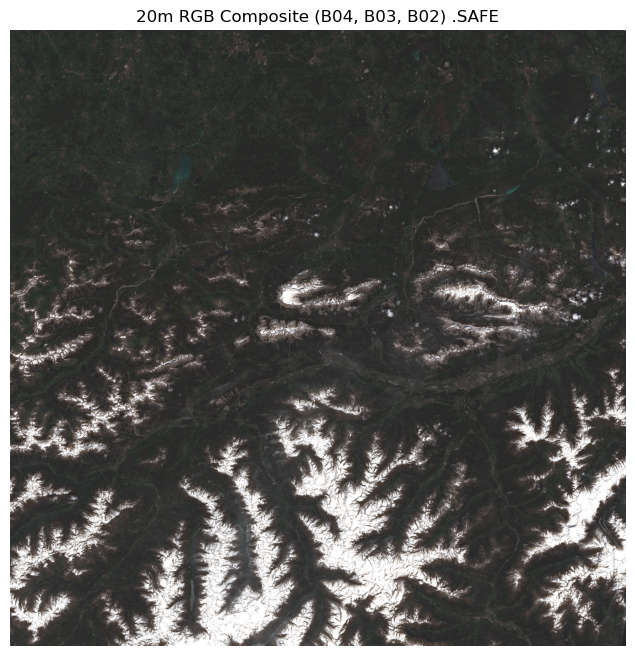

Running time: 2.087 sec
Bands file Size: 96.6 MB


In [ ]:
# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(rgb_safe)
plt.title('20m RGB Composite (B04, B03, B02) .SAFE')
plt.axis('off') # Hide axes
plt.show()
print(f'Running time: {(rgb_safe_t):.3f} sec')
print(f'Bands file Size: {(rgb_bands_size):.3} MB')

## `.zarr` rgb

For the `.zarr` encoding input (zarr_input), we are able to retrieve the bands from the group measurements, under the group `'measurements/reflectance/r20m'`

In [ ]:
st = time.time()

# Access the 20m resolution group as the target bands are stored there
zarr_20 = zarr_input['measurements/reflectance/r20m']

r_20_zarr = zarr_20.b04.astype(float)
g_20_zarr = zarr_20.b03.astype(float)
b_20_zarr = zarr_20.b02.astype(float)


Once retrieved and converted to our data type of interest, we again apply our `xarray` version of the normalisation process for `.zarr` bands, and stack our assets, which will create the **RGB** final composite to be displayed:

In [ ]:
# Apply the normalisation function for xarray
r_norm_z = norm_band_zarr(r_20_zarr, enhance_contrast= True)
g_norm_z = norm_band_zarr(g_20_zarr, enhance_contrast= True)
b_norm_z = norm_band_zarr(b_20_zarr, enhance_contrast= True)

# Stack the bands for the composite
rgb_zarr = np.stack([r_norm_z.values, g_norm_z.values, b_norm_z.values], axis=-1)

# Add brightness enhancement
rgb_zarr = (rgb_zarr+0.15)

et = time.time()

zarr_safe_t = et-st

And, once more, we can have a visual overview of the constructed **RGB** composite, but for the `.zarr` encoding:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15..1.15].


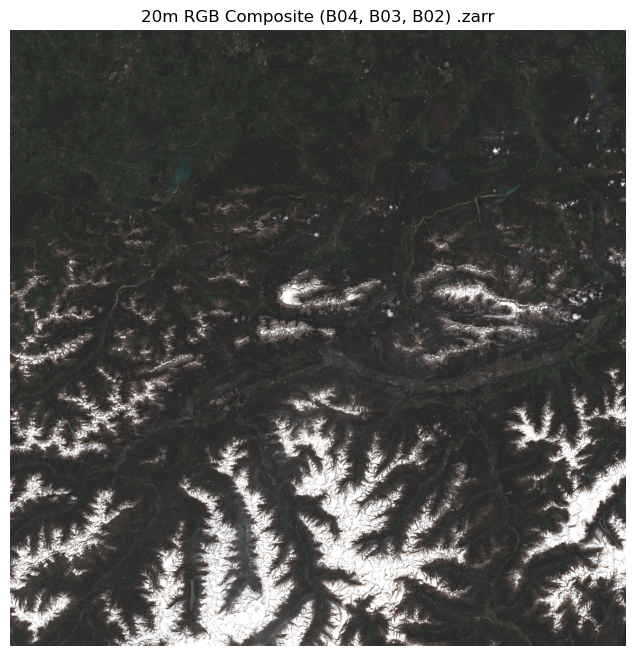

Running time: 12.763 sec


In [ ]:
# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(rgb_zarr)
plt.title('20m RGB Composite (B04, B03, B02) .zarr')
plt.axis('off') # Hide axes
plt.show()

print(f'Running time: {(zarr_safe_t):.3f} sec')

## .SAFE vs. zarr

Using the steps that we have developed, we can compare the differences in performance and data handling between the traditional `.SAFE` format and the modern `.zarr` format, which are mostly based on the local and cloud-based access and processing scenarios.

As a reminder, the key advantages that `.zarr` offers are:

- Effective management of data size
- Optimised time for accessing data
- Improved parallel-processing capabilities and scalability

The results of our comparison are displayed in the following table:

| Metric                   | .SAFE            | .zarr            |
|:-------------------------|:-----------------|:-----------------|
| Download/Search time     | 247.18 seconds   | 4.38 seconds     |
| Downloaded data          | 1.17 GB          | - MB             |
| Quicklook access time    | 0.56 seconds     | 1.44 seconds     |
| Quicklook downloaded size| 3.57 MB          | - MB             |
| RGB downloaded size      | 96.64 MB         | - MB             |
| RGB process time         | 2.10 seconds     | 12.76 seconds    |
| Process code length      | 71 lines         | 56 lines         |

#### Download/Search Time

The `.zarr` format demonstrates advantage in data access speed, with an access time of just 4.38 seconds compared to the 247.18 seconds of `.SAFE`.<br>

This indicates that `.zarr` is far more efficient for quickly locating and retrieving data, avoiding the need to download and process the information locally. <br>

Note that the `.SAFE` item required an additional 4.12 minutes for data access and download through the CDSE API.

#### Full Product Size

The `.SAFE` format, when fully downloaded, results in 1.17 GB of data. In contrast, the .`zarr` format is designed for partial access (lazy loading), meaning we can access just the data covering our area of interest, which is a smaller subset of the entire data file, through the `datatree`.<br>

This makes `.zarr` much more efficient for cloud environments, allowing us to avoid downloading data until we are interested in processing it and only accessing what we need instead of the entire file.

#### Quicklook Time

For quick data previews, the `.SAFE` format shows a faster quicklook access time of 0.56 seconds (since it is processed locally), whereas .`zarr` takes 1.44 seconds. This suggests that generating a quicklook from a `.SAFE` archive might be quicker if the relevant data for the quicklook is readily accessible within its bundled structure.<br>

The `.zarr` format might incur a slight overhead for quicklook generation, possibly due to accessing and decompressing specific chunks for the preview directly form the cloud.

##### RGB Time

While `.zarr` performs faster in the initial data access and efficient partial loading, the `.SAFE` format demonstrates a notable advantage in the actual processing of RGB data, taking only 2.10 seconds compared to `.zarr`'s 12.76 seconds.<br>

This suggests that once the `.SAFE` data is accessed locally, its bundled nature might allow for faster local processing of specific components like RGB imagery.

#### Size

For `.SAFE`, generating a quicklook utilises 3.57 MB of downloaded data. Additionally, the downloaded size of the files for the `.SAFE` RGB composite is 96.64 MB. When it comes to the file size comparison, `.SAFE` uses 100.21 MB from the total data download (8 %), whereas .`zarr` accesses only data from the cloud storage as needed, without downloading the full product.

#### Code Length

The `.zarr` approach requires less code, with 56 Lines compared to the `.SAFE` format's 71 Lines.<br>

This suggests a simpler or more streamlined implementation for data access and processing with `.zarr`.


## 💪 Now it is your turn

With the foundations learned so far, you are now equipped to explore other products characteristics and explore deeper the structure and sizes from the EOPF Zarr STAC catalog.

### Task 1: 

#### Compare the Calculated Normalised Difference Vegetation Index (NDVI) between `.SAFE` and `.zarr` for the current asset.

Explore deeper the `.SAFE` file and find the equivalent groups for the red and near-infrared (NIR) bands at 20m resolution.<br>
**Hint:** Remember that the designated bands for the Sentinel-2 mission are:

- red = b04
- nir = b08

Calculate then the NDVI through `.zarr`

### Task 2: 

#### Explore Sentinel-1 Level-1 GRD
Access the [EOPF STAC Catalog Sentinel-1 Level-1 GDR](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-1-l1-grd) collection and find an equivalent item for the 

Compare the access time and size for:

- VV Data
- VH Noise

## Conclusion

In conclusion, while the traditional `.SAFE` format may offer advantages in specific local processing tasks, the switch to `.zarr` can significantly improve data handling for both providers and consumers<br>

Zarr offers a superior experience for initial data access and scalability, especially with large datasets in cloud environments, by enabling rapid, partial data retrieval. It offers the possibility to access only the assets of our interest reducing unnecessary data downloads. Its `xarray` based lazy-loading, allows us an efficient memory usage.<br>

Performance in cloud-native scenarios is consistently better with `.zarr`, as demonstrated by the much shorter data access time and its efficient lazy-loading capabilities for partial data access. This makes `.zarr` highly advantageous for scalable and remote data handling, ultimately streamlining workflows and reducing the need for extensive local downloads.


## What's next?

Now that you've been introduced to the `.zarr` encoding format, learned its core concepts, and understood the basics of how to explore it, you are prepared for the next step! <br>

In the following [chapter](./31_stac_intro.qmd) we will introduce you to **STAC** and the **EOPF Zarr STAC Catalog**. As we go along, we will transition from theory to practice, providing you with hands-on tutorials working with EOPF `.zarr` products.